### Human-compatibility analysis

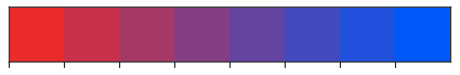

In [321]:
from eval_policy import evaluate_policy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
from utils.policies import load_policy
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO
from nocturne.envs.base_env import BaseEnv
from utils.count_intersecting_paths import create_intersecting_path_dict
import pandas as pd
import numpy as np
import re
import glob
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

IL_COLOR = 'dodgerblue'
sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
os.environ["WANDB_NOTEBOOK_NAME"] = "human_compatible.ipynb"
PALETTE = ['#E92B2B', '#C83149', '#A63866', '#853E84', '#6444A1', '#434ABF', '#2151DC', '#0057FA']
sns.palplot(PALETTE)

In [322]:
# Load dict with number of intersecting paths per scene
with open('../data_full/valid_full.pkl', 'rb') as handle:
    path_int_dict = pickle.load(handle)
df_intersect = pd.DataFrame(path_int_dict)

# Check
#df_intersect.T["intersecting_paths"].value_counts()

### Configurations

In [324]:
# Settings
TOTAL_STEPS = 50_000
CONTROLLED_AGENTS = 1 # Single agent mode

env_config = load_config_nb("env_config")
env_config.data_path = "../data_full/valid/"
env_config.val_data_path = "../data_full/valid/"

# Imitation learning: load human policy
IL_BASE_PATH = "../models/il/S1000"
BC_POLICY_NAME = 'human_policy_S1000_01_12_11_11'

human_policy = load_policy(
    data_path=IL_BASE_PATH,
    file_name=BC_POLICY_NAME, 
)

# Load RL policies
HR_RL_BASE_PATH = "../models/hr_rl/S1000"

# Trained policies
hr_rl_policy_paths = glob.glob(f"{HR_RL_BASE_PATH}" + "/*.zip")
hr_rl_policy_names = [os.path.basename(file)[:-4] for file in hr_rl_policy_paths]
reg_weights = []
pattern = r'L(\d+\.\d+)_S'
for string in hr_rl_policy_names:
    match = re.search(pattern, string)
    if match:
        reg_weights.append(float(match.group(1)))

### 1. Evaluate PPO, HR-PPO and IL policies in **single-agent mode**


In [ ]:
# Set data path
env_config.data_path = "../data_full/valid_full/"

df_comp_rl = pd.DataFrame(
    columns=[
        'scene_id',
        'goal_rate', 
        'off_road', 
        'veh_veh_collision', 
        'num_total_vehs',
        'num_controlled_vehs',
        'reg_weight',
    ],
)

for model_name, reg_weight in zip(hr_rl_policy_names, reg_weights):
    
    # Load RL policy
    policy = RegularizedPPO.load(f"{HR_RL_BASE_PATH}/{model_name}")
    
    # Evaluate
    df_res = evaluate_policy(
        env_config=env_config, 
        mode='policy', 
        scene_path_mapping=df_intersect,
        policy=policy
        controlled_agents=CONTROLLED_AGENTS, 
        total_steps=TOTAL_STEPS
    )

    # Add identifiers
    df_res['reg_weight'] = np.repeat(reg_weight, len(df_res))
    df_res['model_name'] = np.repeat(model_name, len(df_res))

    # Store
    df_comp_rl = pd.concat([df_comp_rl, df_res], ignore_index=True)

In [325]:
# Evaluate
df_comp_il = evaluate_policy(
    env_config=env_config, 
    mode='policy', 
    scene_path_mapping=df_intersect,
    policy=human_policy,
    controlled_agents=CONTROLLED_AGENTS, 
    total_steps=100_000,
)

100%|██████████| 100000/100000 [02:16<00:00, 730.40it/s]


In [48]:
# Save results
df_comp_rl.to_csv('../evaluation/results/df_compatible_rl_test.csv', index=False)
df_comp_il.to_csv('../evaluation/results/df_compatible_il_test.csv', index=False)

### 2. Alternatively, load dataframes if they already exist

In [4]:
# df_comp_rl = pd.read_csv('../evaluation/results/df_compatible_rl_train.csv')
# df_comp_il = pd.read_csv('../evaluation/results/df_compatible_il_train.csv')

In [326]:
df_comp_rl = pd.read_csv('../df_compatible_rl_test_final_1000.csv') # Total timesteps is 300k = 1000 validation scenes

### 3. Categorize the # of intersecting paths and aggregate

In [327]:
# More complex 
BINS = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]
LABELS = ['0', '1', '2', '3', '4', '5',  '6', '7+']

In [329]:
# Categorize
df_comp_rl['num_total_vehs'] = df_comp_rl['num_total_vehs'].astype(int)
df_comp_rl['num_int_paths'] = df_comp_rl['num_int_paths'].astype(int)
df_comp_rl['int_path_cat'] = pd.cut(df_comp_rl['num_int_paths'],
                                       bins=BINS,
                                       labels=LABELS,
                                       include_lowest=True)

df_comp_il['num_total_vehs'] = df_comp_il['num_total_vehs'].astype(int)
df_comp_il['num_int_paths'] = df_comp_il['num_int_paths'].astype(int)
df_comp_il['int_path_cat'] = pd.cut(df_comp_il['num_int_paths'],
                                       bins=BINS,
                                       labels=LABELS,
                                       include_lowest=True)

# Aggregate results
df_rl_agg_comp = df_comp_rl.groupby(['reg_weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_rl_agg_comp['goal_rate'] = df_rl_agg_comp['goal_rate'] * 100
df_rl_agg_comp['off_road'] = df_rl_agg_comp['off_road'] * 100
df_rl_agg_comp['veh_veh_collision'] = df_rl_agg_comp['veh_veh_collision'] * 100

df_il_agg_comp = df_comp_il.groupby(['int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_il_agg_comp['goal_rate'] = df_il_agg_comp['goal_rate'] * 100
df_il_agg_comp['off_road'] = df_il_agg_comp['off_road'] * 100
df_il_agg_comp['veh_veh_collision'] = df_il_agg_comp['veh_veh_collision'] * 100

print(df_comp_rl.shape)
df_comp_rl.head()

(64693, 10)


,scene_id,goal_rate,off_road,veh_veh_collision,num_total_vehs,num_controlled_vehs,reg_weight,num_int_paths,model_name,int_path_cat
0,tfrecord-00008-of-00150_151.json,0,0,1,2,1,0.01,0,policy_L0.01_S1000_I605,0
1,tfrecord-00007-of-00150_237.json,1,0,0,2,1,0.01,0,policy_L0.01_S1000_I605,0
2,tfrecord-00010-of-00150_162.json,0,0,1,12,1,0.01,3,policy_L0.01_S1000_I605,3
3,tfrecord-00008-of-00150_253.json,1,0,0,4,1,0.01,0,policy_L0.01_S1000_I605,0
4,tfrecord-00010-of-00150_219.json,1,0,0,8,1,0.01,2,policy_L0.01_S1000_I605,2


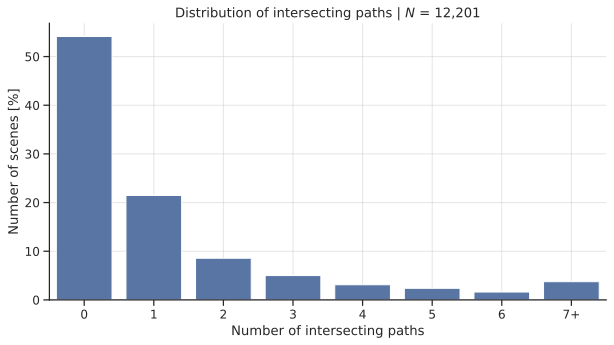

In [330]:
# More complex 
BINS = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]
LABELS = ['0', '1', '2', '3', '4', '5',  '6', '7+']
df = df_intersect.T.reset_index()
df['int_cat'] = pd.cut(df['intersecting_paths'], bins=BINS, labels=LABELS, include_lowest=True)
ax = sns.countplot(x='int_cat', data=df, stat='percent')

plt.title(f'Distribution of intersecting paths | $N$ = {df.index.unique().shape[0]:,}')
plt.ylabel('Number of scenes [%]')
plt.xlabel('Number of intersecting paths')
plt.grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/dist_intersecting_paths_test_set.pdf', bbox_inches="tight")

In [331]:
# df_rl_agg_comp.style.format('{:.1f}', na_rep="")\
#     .bar(subset=['veh_veh_collision'], align=0, vmin=0, vmax=100, cmap="Reds", height=50, width=60)\
#     .set_caption("<h3>Aggregated HR-PPO collision rate with human experts</h3>").format("{:.2f}")

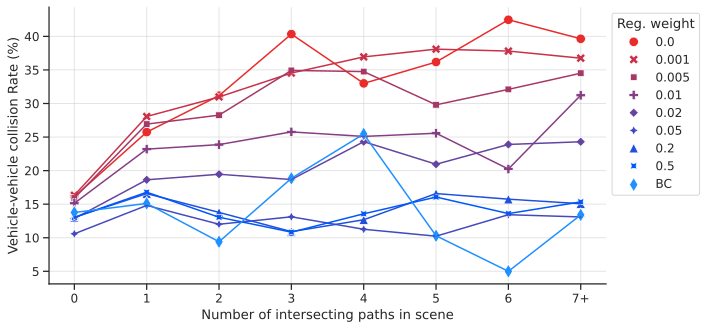

In [347]:
# Assuming df is your DataFrame
# Reset the index to make 'reg_weight' and 'int_path_cat' regular columns
df_reset_rl = df_rl_agg_comp.reset_index()
df_reset_il = df_il_agg_comp.reset_index()

# Convert 'reg_weight' and 'int_path_cat' to categorical
df_reset_rl['reg_weight'] = pd.Categorical(df_reset_rl['reg_weight'])
df_reset_rl['int_path_cat'] = pd.Categorical(df_reset_rl['int_path_cat'])

# HR-PPO
sns.scatterplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_rl, hue='reg_weight', style='reg_weight', palette=PALETTE, marker='o', s=90)
sns.lineplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_rl, hue='reg_weight', palette=PALETTE, legend=False)

# IL
sns.lineplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_il, legend=True, c=IL_COLOR)
sns.scatterplot(x='int_path_cat', y='veh_veh_collision', data=df_reset_il, marker='d', s=100, c=IL_COLOR, legend=True, label='BC')

# Set labels and title
plt.xlabel('Number of intersecting paths in scene')
plt.ylabel('Vehicle-vehicle collision Rate (%)')
plt.legend(title='Reg. weight', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.5)
sns.despine()

plt.savefig(f'../evaluation/figures/compatible_ma_collision_test.pdf', bbox_inches="tight")

In [356]:
df_comp_il

,scene_id,goal_rate,off_road,veh_veh_collision,num_total_vehs,num_controlled_vehs,num_int_paths,int_path_cat
0,tfrecord-00060-of-00150_173.json,1,0,0,3,1,0,0
1,tfrecord-00092-of-00150_95.json,1,0,1,3,1,0,0
2,tfrecord-00032-of-00150_5.json,1,1,0,4,1,1,1
3,tfrecord-00100-of-00150_27.json,0,1,0,5,1,0,0
4,tfrecord-00090-of-00150_67.json,1,0,0,9,1,0,0
...,...,...,...,...,...,...,...,...
2102,tfrecord-00019-of-00150_21.json,0,1,0,4,1,2,2
2103,tfrecord-00025-of-00150_280.json,1,0,0,11,1,0,0
2104,tfrecord-00034-of-00150_145.json,1,0,0,10,1,1,1
2105,tfrecord-00106-of-00150_221.json,0,1,0,10,1,0,0


In [349]:
# Select the PPO model and the HR-PPO models with reg_weights 0.0, 0.05, 0.2
df_rl_filtered = df_reset_rl[df_reset_rl['reg_weight'].isin([0.0, 0.02, 0.05])]

In [341]:
df_rl_filtered

,reg_weight,int_path_cat,goal_rate,off_road,veh_veh_collision
0,0.00,0,80.435225,3.823470,16.107383
1,0.00,1,69.664083,5.271318,25.736434
2,0.00,2,66.341991,3.896104,31.168831
3,0.00,3,58.598726,2.123142,40.339703
4,0.00,4,59.595960,7.070707,32.996633
5,0.00,5,57.337884,7.508532,36.177474
6,0.00,6,54.838710,5.913978,42.473118
7,0.00,7+,56.756757,5.705706,39.639640
32,0.02,0,79.147142,7.591378,12.863168
33,0.02,1,74.355902,6.830437,18.633913


In [342]:
# Subtract values from reg_weight == 0
df_diff = df_rl_filtered.copy()
df_diff[['off_road', 'veh_veh_collision']] = df_rl_filtered.groupby('int_path_cat')[['off_road', 'veh_veh_collision']].transform(lambda x: x.iloc[0] - x)
df_diff[['goal_rate']] = df_rl_filtered.groupby('int_path_cat')[['goal_rate']].transform(lambda x: x - x.iloc[0])

In [343]:
# Subtract values from reg_weight == 0
df_diff = df_rl_filtered.copy()
df_diff[['off_road', 'veh_veh_collision']] = df_rl_filtered.groupby('int_path_cat')[['off_road', 'veh_veh_collision']].transform(lambda x: x.iloc[0] - x)
df_diff[['goal_rate']] = df_rl_filtered.groupby('int_path_cat')[['goal_rate']].transform(lambda x: x - x.iloc[0])

,reg_weight,int_path_cat,goal_rate,off_road,veh_veh_collision
0,0.00,0,0.000000,0.000000,0.000000
1,0.00,1,0.000000,0.000000,0.000000
2,0.00,2,0.000000,0.000000,0.000000
3,0.00,3,0.000000,0.000000,0.000000
4,0.00,4,0.000000,0.000000,0.000000
5,0.00,5,0.000000,0.000000,0.000000
6,0.00,6,0.000000,0.000000,0.000000
7,0.00,7+,0.000000,0.000000,0.000000
32,0.02,0,-1.288083,-3.767908,3.244215
33,0.02,1,4.691819,-1.559120,7.102522


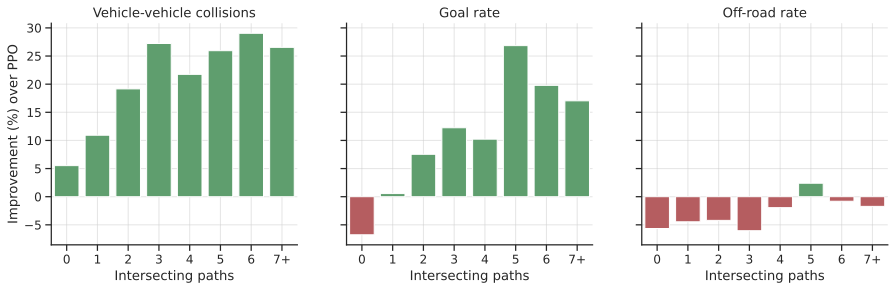

In [354]:
REG_WEIGHT = 0.05
PAL = ['g', 'r']

df_select = df_diff[df_diff['reg_weight'] == REG_WEIGHT]

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Compare to PPO
colors = [1 if c >= 0 else 0 for c in df_select['veh_veh_collision']]
sns.barplot(x='int_path_cat', y='veh_veh_collision', hue=colors, data=df_select, palette=PAL, ax=axs[0], legend=False)
axs[0].set_title('Vehicle-vehicle collisions')

colors = [1 if c < 0 else 0 for c in df_select['goal_rate']]
sns.barplot(x='int_path_cat', y='goal_rate', data=df_select, hue=colors, palette=PAL, ax=axs[1], legend=False)
axs[1].set_title('Goal rate')

colors = [1 if c < 0 else 0 for c in df_select['off_road']]
sns.barplot(x='int_path_cat', y='off_road', data=df_select, hue=colors, palette=PAL, ax=axs[2], legend=False)
axs[2].set_title('Off-road rate')

axs[0].grid(True, alpha=0.5), axs[1].grid(True, alpha=0.5), axs[2].grid(True, alpha=0.5)

axs[0].set_ylabel('Improvement (%) over PPO')
axs[0].set_xlabel('Intersecting paths')
axs[1].set_xlabel('Intersecting paths')
axs[2].set_xlabel('Intersecting paths')
sns.despine()

plt.savefig(f'../evaluation/figures/compatible_reg_{REG_WEIGHT}_to_ppo_comparison_test_set.pdf', bbox_inches="tight")

In [89]:
df_rl_agg_comp

goal_rate   off_road  veh_veh_collision       diff
reg_weight int_path_cat                                                    
0.0        0             80.435225   3.823470          16.107383   0.000000
           1             69.664083   5.271318          25.736434   9.629052
           2             66.341991   3.896104          31.168831  15.061449
           3             58.598726   2.123142          40.339703  24.232320
           4             59.595960   7.070707          32.996633  16.889250
...                            ...        ...                ...        ...
0.5        3             56.965944  11.145511          10.835913  -5.271469
           4             55.778894  11.557789          13.567839  -2.539543
           5             59.067358  12.953368          16.062176  -0.045206
           6             48.800000  14.400000          13.600000  -2.507383
           7+            53.023256  13.023256          15.348837  -0.758545

[64 rows x 4 columns]

In [357]:
df_reset_il

,int_path_cat,goal_rate,off_road,veh_veh_collision
0,0,38.010657,29.928952,13.765542
1,1,43.073048,31.989924,15.11335
2,2,40.594059,28.217822,9.405941
3,3,59.016393,9.016393,18.852459
4,4,47.272727,14.545455,25.454545
5,5,79.411765,4.411765,10.294118
6,6,75.0,10.0,5.0
7,7+,62.886598,19.587629,13.402062


In [380]:
df_agg_total_rl = df_comp_rl.groupby('reg_weight')[['goal_rate', 'veh_veh_collision', 'off_road']].mean()
df_agg_total_il = df_comp_il[['goal_rate', 'veh_veh_collision', 'off_road']].mean()

In [381]:
df_agg_total_il

goal_rate            0.438538
veh_veh_collision     0.13906
off_road             0.268628
dtype: object

In [379]:
df_agg_total_rl.round(2)

,goal_rate,veh_veh_collision,off_road
reg_weight,,,
0.000,0.73,0.23,0.04
0.001,0.71,0.24,0.06
0.005,0.74,0.22,0.05
0.010,0.76,0.20,0.04
0.020,0.77,0.16,0.07
0.050,0.73,0.12,0.09
0.200,0.56,0.14,0.14
0.500,0.48,0.14,0.18


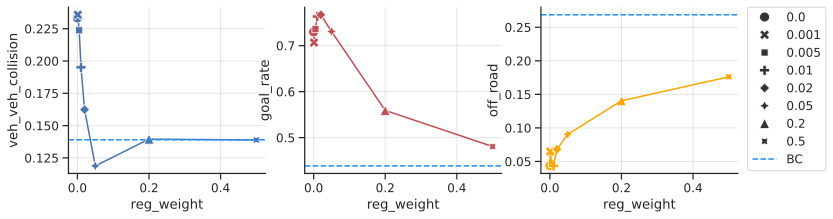

In [377]:
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
mpl.rcParams['lines.markersize'] = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.lineplot(data=df_agg_total_rl, x="reg_weight", y="veh_veh_collision", ax=axes[0])
sns.lineplot(data=df_agg_total_rl, x="reg_weight", y="veh_veh_collision", style="reg_weight", markers=True, color='b', dashes=False, ax=axes[0], legend=False)

# IL
axes[0].axhline(y=df_agg_total_il["veh_veh_collision"], color=IL_COLOR, linestyle='--', label='BC')

sns.lineplot(data=df_agg_total_rl, x="reg_weight", y="goal_rate", color='r', ax=axes[1])
sns.lineplot(data=df_agg_total_rl, x="reg_weight", y="goal_rate", style="reg_weight", markers=True, color='r', dashes=False, ax=axes[1], legend=False)

# IL
axes[1].axhline(y=df_agg_total_il["goal_rate"], color=IL_COLOR, linestyle='--', label='BC')

sns.lineplot(x='reg_weight', y='off_road', data=df_agg_total_rl, c='orange', ax=axes[2], legend=False)
sns.scatterplot(x='reg_weight', y='off_road', data=df_agg_total_rl, marker='d', style='reg_weight', s=100, c='orange', legend=True, ax=axes[2])

# IL
axes[2].axhline(y=df_agg_total_il["off_road"], color=IL_COLOR, linestyle='--', label='BC')

axes[0].grid(True, alpha=.5), axes[1].grid(True, alpha=.5), axes[2].grid(True, alpha=.5)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine()

### Get dict

In [28]:
# Make env
env_config.max_num_vehicles = 20
env = BaseEnv(env_config)
env_config.data_path = "../data_full/valid_full/"

In [29]:
# Scenes on which to evaluate the models
# Make sure file order is fixed so that we evaluate on the same files used for training
file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
eval_files = sorted([os.path.basename(file) for file in file_paths])

In [30]:
df_intersect = create_intersecting_path_dict(env=env, traffic_scenes=eval_files, save_as='valid_full')

100%|██████████| 12201/12201 [29:14<00:00,  6.96it/s]  


In [33]:
df_intersect

,tfrecord-00000-of-00150_101.json,tfrecord-00000-of-00150_102.json,tfrecord-00000-of-00150_103.json,tfrecord-00000-of-00150_105.json,tfrecord-00000-of-00150_108.json,tfrecord-00000-of-00150_109.json,tfrecord-00000-of-00150_119.json,tfrecord-00000-of-00150_122.json,tfrecord-00000-of-00150_125.json,tfrecord-00000-of-00150_128.json,...,tfrecord-00149-of-00150_66.json,tfrecord-00149-of-00150_69.json,tfrecord-00149-of-00150_72.json,tfrecord-00149-of-00150_75.json,tfrecord-00149-of-00150_77.json,tfrecord-00149-of-00150_79.json,tfrecord-00149-of-00150_85.json,tfrecord-00149-of-00150_86.json,tfrecord-00149-of-00150_93.json,tfrecord-00149-of-00150_94.json
intersecting_paths,1,0,0,0,1,0,2,5,0,0,...,0,1,2,0,2,0,6,5,0,0
num_agents,19,2,4,5,7,3,6,16,7,7,...,6,2,10,5,12,3,13,13,4,2
